In [1]:
from lumberjack_tools import *

Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1
TaLib version  0.4.19
FinTA version  1.3


## Chargement de la base, K-Lines, Application de stratégie (=> Signal)

In [28]:
%%time
df = pd.read_excel('pima_indians.xlsx')
print(df.Class.value_counts())
df.head()

0    500
1    268
Name: Class, dtype: int64
CPU times: user 110 ms, sys: 1.7 ms, total: 112 ms
Wall time: 111 ms


,Time_Pregnant,PGC,Dias_BP,Tri_SkinFold,SI,BMI,DPF,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Préparation de df et sauvgarde de df_raw

## Features Transformation

In [27]:
%%time
# Colonnes non traitées

# différences sur 1, 2, 3, 4 et 5 bougies
#df = feature_diff(df)

# Transformation par les inverse, carré, cos, sin, log et tan
df = feature_transformation(df)

df.shape

CPU times: user 27.3 ms, sys: 1.74 ms, total: 29 ms
Wall time: 27.4 ms


(768, 49)

## Split des jeux d'entrainement et mise à l'échelle

In [29]:
%%time
from sklearn.model_selection import train_test_split
# Séparation en jeux d'entrainement, de test et séparation du jeu out of sample
X = df.drop(['Class'],axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)


# Choix du scaler
scaler = MinMaxScaler()

# Mise à l'échelle
df = feature_scaling(df,scaler)


CPU times: user 8.97 ms, sys: 1.27 ms, total: 10.2 ms
Wall time: 9.22 ms


## Feature Selection

In [5]:
%%time
# Si selection en Univariate
#X_train, X_test = univariate_feature_selection(X_train, X_test, y_train, 32)

# Si selection par l1
X_train, X_test = l1_feature_selection(X_train, X_test, y_train, 1)

# Vérification des shapes
X_train.shape, X_test.shape

CPU times: user 15.4 ms, sys: 1.85 ms, total: 17.2 ms
Wall time: 16.2 ms


((514, 12), (254, 12))

## Entrainement

In [30]:
%%time
# Affectatioon de poids différents en fonction des clases
class_weight = affect_weight(y_train)
BATCH_SIZE = 12
# Construction du modèle
_first_a = 'relu'
_a='relu'
_last_a='sigmoid'
model = make_model(X_train, _first_a, _a, _last_a, BATCH_SIZE)

# Compilation du modèlé
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=20, mode='max', restore_best_weights=True)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = compile_model(model,METRICS=METRICS)



Initial bias [0.73133097]

Weight for class 0: 1.54
Weight for class 1: 0.74
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 63)                567       
_________________________________________________________________
dropout_18 (Dropout)         (None, 63)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8192      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
___________________________________________

## Evaluation du meilleur Batch

In [22]:
%%time
# Evaluation du meilleur batch
_borne = int(X_train.shape[0])
_step = 1
BATCH_SIZE = evaluate_batch(model, X_train, y_train,_borne,_step)

100%|██████████| 504/504 [00:05<00:00, 93.48it/s] Meilleur Loss: 0.6991
Meilleur Batch: 510.0000
CPU times: user 7.82 s, sys: 1.54 s, total: 9.36 s
Wall time: 5.39 s



## Fit the model

Train on 514 samples, validate on 254 samples
Epoch 1/200
514/514 [==============================] - 1s 2ms/sample - loss: 1.3802 - tp: 90.0000 - fp: 179.0000 - tn: 168.0000 - fn: 77.0000 - accuracy: 0.5019 - precision: 0.3346 - recall: 0.5389 - auc: 0.5345 - prc: 0.3648 - val_loss: 0.6868 - val_tp: 48.0000 - val_fp: 40.0000 - val_tn: 113.0000 - val_fn: 53.0000 - val_accuracy: 0.6339 - val_precision: 0.5455 - val_recall: 0.4752 - val_auc: 0.5972 - val_prc: 0.5575
Epoch 2/200
514/514 [==============================] - 0s 194us/sample - loss: 0.8046 - tp: 60.0000 - fp: 113.0000 - tn: 234.0000 - fn: 107.0000 - accuracy: 0.5720 - precision: 0.3468 - recall: 0.3593 - auc: 0.5067 - prc: 0.3284 - val_loss: 0.6819 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 153.0000 - val_fn: 100.0000 - val_accuracy: 0.6063 - val_precision: 1.0000 - val_recall: 0.0099 - val_auc: 0.5880 - val_prc: 0.5097
Epoch 3/200
514/514 [==============================] - 0s 194us/sample - loss: 0.7668 - tp: 33.0000 - fp

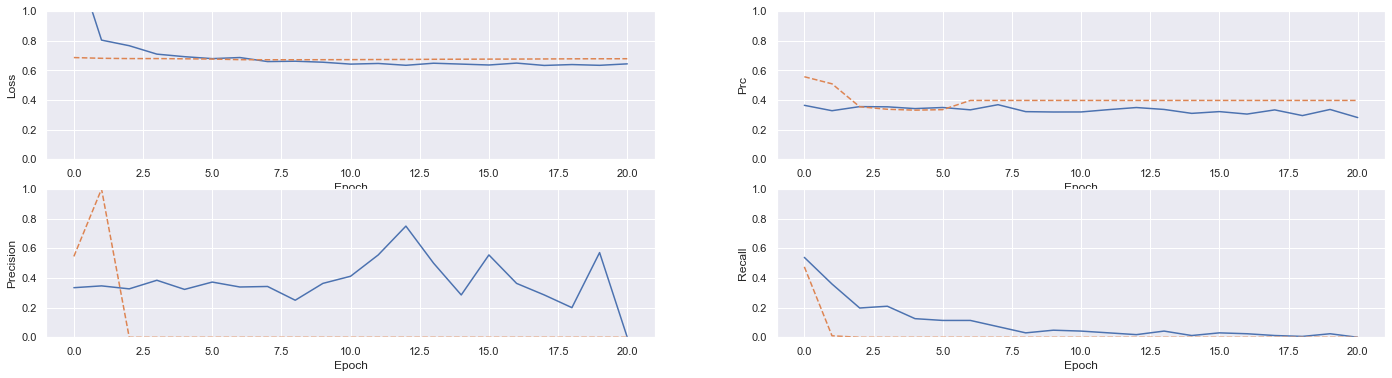

In [31]:

epochs=200

history = fit_model(X_train,y_train,X_test,y_test,model,epochs=epochs,BATCH_SIZE=BATCH_SIZE,callbacks=[early_stopping],class_weight=class_weight)

In [32]:
%%time
_edge = (min(model.predict(X_test))[0]+max(model.predict(X_test))[0])/2
yhat = pd.DataFrame()
PREDICTAT = []
PREDICT = model.predict(X_test)
for i in tqdm(range(len(PREDICT))):
    if PREDICT[i] <= _edge:
        PREDICTAT.append(0)
    else:
        PREDICTAT.append(1)
yhat['Predict'] = PREDICTAT

100%|██████████| 254/254 [00:00<00:00, 419926.38it/s]CPU times: user 29.8 ms, sys: 7.29 ms, total: 37.1 ms
Wall time: 24.6 ms



Signaux - Accuracy : 65.35 %
Signaux - Precision : 72.41 %
Signaux - Recall : 20.79 %
Achat - F-measure: : 32.31 %


              precision    recall  f1-score   support

           0       0.64      0.95      0.77       153
           1       0.72      0.21      0.32       101

    accuracy                           0.65       254
   macro avg       0.68      0.58      0.55       254
weighted avg       0.68      0.65      0.59       254

         Positifs Négatifs
Positifs       21       80
Négatifs        8      145

Vrais signaux positifs trouvés    :  21
Vrais signaux positifs non trouvé : 80
Total des signaux posistifs : 101
 Précision : 72.41 % 
 Recall : 20.79 % 
 F-Score : 32.3 % 


Vrais signaux négatifs trouvés    :  145
Vrais signaux négatifs non trouvé : 8
Total des signaux négatifs : 153
 Precision :  64.44 %
 Recall : 94.77 % 
 F-Score : 76.72 % 


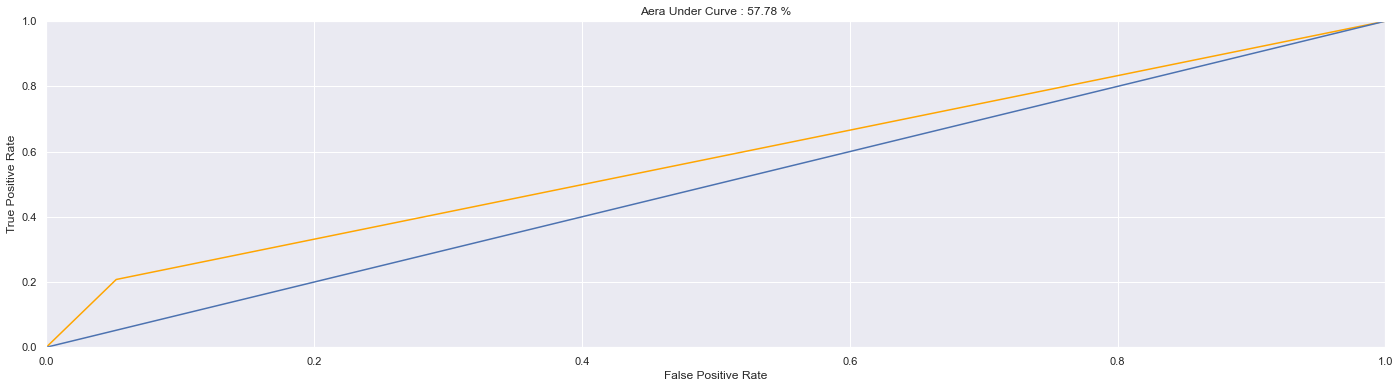

In [33]:
get_results(y_test,yhat)